<a href="https://colab.research.google.com/github/numberjuani/crypto_cash_carry/blob/main/Cash_and_Carry_Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install binance-connector
!pip3 install binance-futures-connector

In [ ]:
from binance.spot import Spot as SpotClient
from binance.delivery import Delivery as FuturesClient
import pandas as pd
%load_ext google.colab.data_table

First we establish clients to the spot, and COIN-M margined futures.

In [110]:
spot_client = SpotClient()
futures_client = FuturesClient()

Now we obtain information for all listed contracts under the COIN-M futures, which will allows to filter by those with a valid expiration date, ignoring perpetuals.

In [111]:
coin_m_futures_info = pd.DataFrame(futures_client.exchange_info()['symbols'])
coin_m_futures_info['deliveryDate'] = pd.to_datetime(coin_m_futures_info['deliveryDate'],unit='ms')
#remove all perpetual contracts from the list
coin_m_futures_info = coin_m_futures_info[coin_m_futures_info.contractType != 'PERPETUAL']
coin_m_futures_info = coin_m_futures_info[['symbol','contractType','marginAsset','deliveryDate']]
coin_m_futures_info

,symbol,contractType,marginAsset,deliveryDate
1,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00
2,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00
4,ETHUSD_220624,CURRENT_QUARTER,ETH,2022-06-24 08:00:00
5,ETHUSD_220930,NEXT_QUARTER,ETH,2022-09-30 08:00:00
33,ADAUSD_220624,CURRENT_QUARTER,ADA,2022-06-24 08:00:00
34,LINKUSD_220624,CURRENT_QUARTER,LINK,2022-06-24 08:00:00
35,BCHUSD_220624,CURRENT_QUARTER,BCH,2022-06-24 08:00:00
36,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00
37,XRPUSD_220624,CURRENT_QUARTER,XRP,2022-06-24 08:00:00
38,LTCUSD_220624,CURRENT_QUARTER,LTC,2022-06-24 08:00:00


Now we obtain prices for all the futures, and filter by the contracts that do expire, which we obtained in the previous step.

In [112]:
non_perpetual_symbols = coin_m_futures_info.symbol.values

In [113]:
coin_m_futures_pricing = pd.DataFrame(futures_client.book_ticker())
non_perpetual = coin_m_futures_pricing[coin_m_futures_pricing.symbol.isin(non_perpetual_symbols)]
#since we'll be selling the futures we'll keep the bid price.
non_perpetual = non_perpetual[['symbol','bidPrice']]
non_perpetual

,symbol,bidPrice
29,BTCUSD_220624,39685.0
30,ETHUSD_220624,2949.84
31,ADAUSD_220624,0.89120
32,LINKUSD_220624,13.408
33,BCHUSD_220624,310.52
34,DOTUSD_220624,18.054
35,XRPUSD_220624,0.7049
36,LTCUSD_220624,105.30
37,BNBUSD_220624,393.155
45,BTCUSD_220930,40087.0


Now we consolidate all the futures data into one dataframe.

In [114]:
futures = pd.merge(coin_m_futures_info,non_perpetual,on='symbol')
futures

,symbol,contractType,marginAsset,deliveryDate,bidPrice
0,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39685.0
1,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,40087.0
2,ETHUSD_220624,CURRENT_QUARTER,ETH,2022-06-24 08:00:00,2949.84
3,ETHUSD_220930,NEXT_QUARTER,ETH,2022-09-30 08:00:00,2973.48
4,ADAUSD_220624,CURRENT_QUARTER,ADA,2022-06-24 08:00:00,0.89120
5,LINKUSD_220624,CURRENT_QUARTER,LINK,2022-06-24 08:00:00,13.408
6,BCHUSD_220624,CURRENT_QUARTER,BCH,2022-06-24 08:00:00,310.52
7,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,18.054
8,XRPUSD_220624,CURRENT_QUARTER,XRP,2022-06-24 08:00:00,0.7049
9,LTCUSD_220624,CURRENT_QUARTER,LTC,2022-06-24 08:00:00,105.30


The spot endpoint has an incredibly large number of coins, so we have to narrow it down by those that have a coin-m futures that expire and those that trade with a dollar quote.

In [115]:
coins_to_consider = futures.marginAsset.values.tolist()
#as of right now these are all the stablecoins that are listed on the spot exchange
quotes_to_consider = ['USD','USDT','BUSD','USDS','USDP','DAI','USDC','TUSD']

In [116]:
spot_info = pd.DataFrame(spot_client.exchange_info()['symbols'])
spot_info = spot_info[spot_info.baseAsset.isin(coins_to_consider) & (spot_info.quoteAsset.isin(quotes_to_consider))]
spot_info = spot_info[['symbol','baseAsset','quoteAsset']]
spot_info

,symbol,baseAsset,quoteAsset
11,BTCUSDT,BTC,USDT
12,ETHUSDT,ETH,USDT
98,BNBUSDT,BNB,USDT
190,LTCUSDT,LTC,USDT
296,ADAUSDT,ADA,USDT
306,XRPUSDT,XRP,USDT
312,BTCTUSD,BTC,TUSD
314,ETHTUSD,ETH,TUSD
412,BNBTUSD,BNB,TUSD
413,XRPTUSD,XRP,TUSD


In [117]:
spot_prices = pd.DataFrame(spot_client.ticker_24hr())
spot_prices = spot_prices[spot_prices.symbol.isin(spot_info.symbol)]
#since the spot needs to be bought, we will save the ask price.
spot_prices = spot_prices[['symbol','askPrice']]
spot_prices

,symbol,askPrice
11,BTCUSDT,39577.75000000
12,ETHUSDT,2939.71000000
98,BNBUSDT,400.60000000
190,LTCUSDT,104.90000000
296,ADAUSDT,0.88800000
306,XRPUSDT,0.70020000
312,BTCTUSD,39604.59000000
314,ETHTUSD,2941.13000000
412,BNBTUSD,400.70000000
413,XRPTUSD,0.70110000


Now we merge spot info with its pricing data, like we did before.

In [118]:
spot_info = pd.merge(spot_prices,spot_info,on='symbol')
spot_info

,symbol,askPrice,baseAsset,quoteAsset
0,BTCUSDT,39577.75000000,BTC,USDT
1,ETHUSDT,2939.71000000,ETH,USDT
2,BNBUSDT,400.60000000,BNB,USDT
3,LTCUSDT,104.90000000,LTC,USDT
4,ADAUSDT,0.88800000,ADA,USDT
5,XRPUSDT,0.70020000,XRP,USDT
6,BTCTUSD,39604.59000000,BTC,TUSD
7,ETHTUSD,2941.13000000,ETH,TUSD
8,BNBTUSD,400.70000000,BNB,TUSD
9,XRPTUSD,0.70110000,XRP,TUSD


Now we finally are ready to merge spot and futures pairs.

In [119]:
spot_and_futures_combo = pd.merge(spot_info,futures,left_on='baseAsset',right_on='marginAsset',suffixes=('_spot', '_future'))
spot_and_futures_combo

,symbol_spot,askPrice,baseAsset,quoteAsset,symbol_future,contractType,marginAsset,deliveryDate,bidPrice
0,BTCUSDT,39577.75000000,BTC,USDT,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39685.0
1,BTCUSDT,39577.75000000,BTC,USDT,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,40087.0
2,BTCTUSD,39604.59000000,BTC,TUSD,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39685.0
3,BTCTUSD,39604.59000000,BTC,TUSD,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,40087.0
4,BTCUSDC,39592.18000000,BTC,USDC,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,39685.0
...,...,...,...,...,...,...,...,...,...
79,BCHBUSD,309.60000000,BCH,BUSD,BCHUSD_220930,NEXT_QUARTER,BCH,2022-09-30 08:00:00,313.13
80,DOTBUSD,18.28000000,DOT,BUSD,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,18.054
81,DOTBUSD,18.28000000,DOT,BUSD,DOTUSD_220930,NEXT_QUARTER,DOT,2022-09-30 08:00:00,17.895
82,DOTUSDT,18.28000000,DOT,USDT,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,18.054


In [120]:
spot_and_futures_combo['bidPrice'] = spot_and_futures_combo['bidPrice'].astype(float)
spot_and_futures_combo['askPrice'] = spot_and_futures_combo['askPrice'].astype(float)
spot_and_futures_combo = spot_and_futures_combo[spot_and_futures_combo['askPrice'] != 0].copy()
spot_and_futures_combo['price_difference'] = spot_and_futures_combo['bidPrice'] - spot_and_futures_combo['askPrice']
spot_and_futures_combo['price_difference_pct'] = 100*(spot_and_futures_combo['price_difference']/spot_and_futures_combo['askPrice'])
spot_and_futures_combo['days_to_expiration'] = (spot_and_futures_combo.deliveryDate - pd.Timestamp.today()).dt.days
spot_and_futures_combo['return'] = spot_and_futures_combo['price_difference_pct']/spot_and_futures_combo['days_to_expiration']
spot_and_futures_combo['annual_ror'] =  365*(spot_and_futures_combo['return']/spot_and_futures_combo['days_to_expiration'])
#for the sake of simplicity we will remove all coins with negative return for the trade, however, something worth noting might be happening with coins deep in negative terriroty, thats for you to look into
spot_and_futures_combo = spot_and_futures_combo[spot_and_futures_combo['annual_ror'] > 0]
spot_and_futures_combo.sort_values(by='annual_ror',inplace=True,ascending=False)
trades = spot_and_futures_combo[['symbol_spot','symbol_future','days_to_expiration','baseAsset','quoteAsset','bidPrice','askPrice','price_difference','price_difference_pct','return','annual_ror']]
trades

,symbol_spot,symbol_future,days_to_expiration,baseAsset,quoteAsset,bidPrice,askPrice,price_difference,price_difference_pct,return,annual_ror
62,XRPBUSD,XRPUSD_220624,60,XRP,BUSD,0.70490,0.7002,0.00470,0.671237,0.011187,0.068056
56,XRPUSDT,XRPUSD_220624,60,XRP,USDT,0.70490,0.7002,0.00470,0.671237,0.011187,0.068056
60,XRPUSDC,XRPUSD_220624,60,XRP,USDC,0.70490,0.7007,0.00420,0.599401,0.009990,0.060773
58,XRPTUSD,XRPUSD_220624,60,XRP,TUSD,0.70490,0.7011,0.00380,0.542005,0.009033,0.054953
44,LTCUSDC,LTCUSD_220624,60,LTC,USDC,105.30000,104.9000,0.40000,0.381316,0.006355,0.038661
40,LTCUSDT,LTCUSD_220624,60,LTC,USDT,105.30000,104.9000,0.40000,0.381316,0.006355,0.038661
46,LTCBUSD,LTCUSD_220624,60,LTC,BUSD,105.30000,104.9000,0.40000,0.381316,0.006355,0.038661
48,ADAUSDT,ADAUSD_220624,60,ADA,USDT,0.89120,0.8880,0.00320,0.360360,0.006006,0.036537
54,ADABUSD,ADAUSD_220624,60,ADA,BUSD,0.89120,0.8880,0.00320,0.360360,0.006006,0.036537
52,ADAUSDC,ADAUSD_220624,60,ADA,USDC,0.89120,0.8880,0.00320,0.360360,0.006006,0.036537


Let's take a look at where the premiums are in general terms

In [121]:
premia = trades.groupby('baseAsset').mean()
premia.sort_values(by='annual_ror',inplace=True,ascending=False)

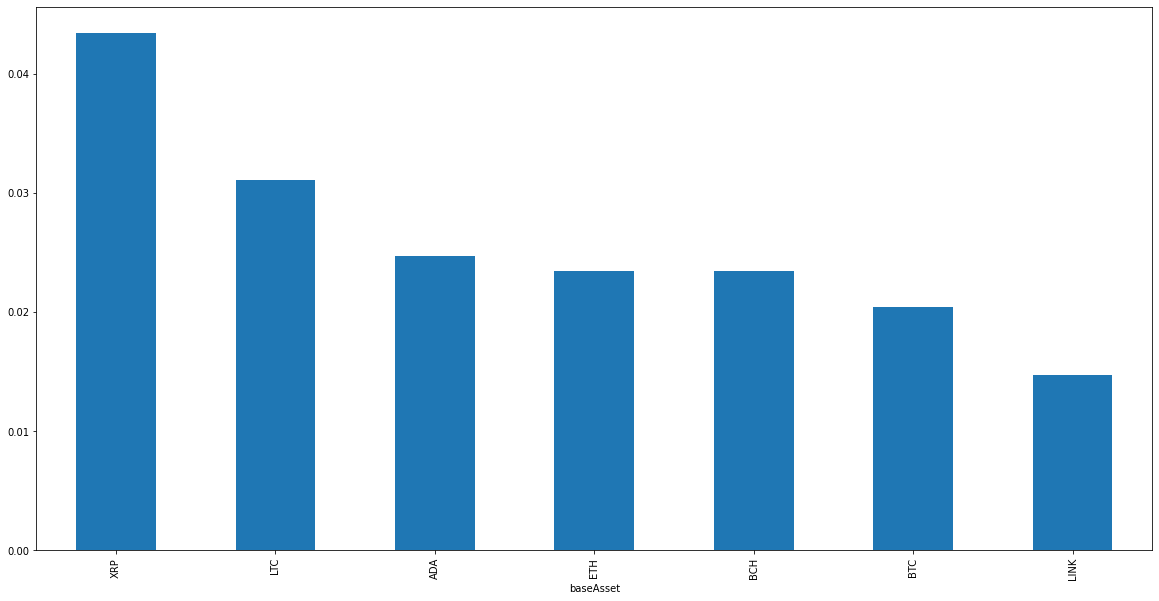

In [122]:
premia.annual_ror.plot(figsize=(20,10),kind='bar')